In [15]:
import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from torchinfo import summary
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import FakeData # Test
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import math

Size of data_coins 10000 : Size of labels_coins 10000
Size of data_others 10000 : Size of labels_others 10000


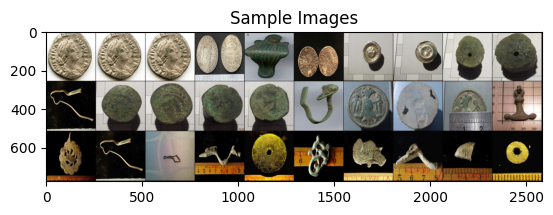

In [2]:
# Load data from external source
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Docs:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

# 256x256 images
path_to_coins = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_coin_256x256/"
path_to_others = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_others_256x256/"

def load_data_from_directory_with_limit(directory_path, label, limit=10000):
    data = []
    labels = []
    count = 0

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"): 
            image_path = os.path.join(directory_path, filename)
            image = read_image(image_path)

            # Check if the image is RGB
            if image.shape[0] == 3:
                data.append(image)
                labels.append(label)
                count += 1

            if count >= limit:
                break

    return data, labels # Tuple

# Load data call
data_coins, labels_coins = load_data_from_directory_with_limit(path_to_coins, label=1, limit=10000)
data_others, labels_others = load_data_from_directory_with_limit(path_to_others, label=0, limit=10000)

print(f'Size of data_coins {len(data_coins)} : Size of labels_coins {len(labels_coins)}')
print(f'Size of data_others {len(data_others)} : Size of labels_others {len(labels_others)}')

def imshow_grid(images, num_images=30):
    grid = torchvision.utils.make_grid(images[:num_images], nrow=10)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title('Sample Images')
    plt.axis('on')
    plt.show()

num_images_to_display_per_category = 15
data_to_display = data_coins[:num_images_to_display_per_category] + data_others[:num_images_to_display_per_category]
imshow_grid(data_to_display, num_images=num_images_to_display_per_category * 2)

In [3]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms
from torchvision.io import read_image
import torch
import torchvision
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

class customDataset(Dataset):
    def __init__(self, tensors, transform=None):
        # Check the sizes of data and labels match
        assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"

        # Assign input
        self.tensors = tensors
        self.transform = transform

    # What to do when we want an item from the dataset
    def __getitem__(self, index):
        # Return the transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else: 
            x = self.tensors[0][index]

        # And return the label too
        y = self.tensors[1][index].view(1) # Convert y to a single-element tensor

        return x,y # Return the data as a tuple (data,label)

    def __len__(self):
        return self.tensors[0].size(0)


# Create a list of  transforms
imgTrans = transforms.Compose(
    [
        transforms.ToPILImage(), # PIL = library for images - Works for several transformations. To PIL image type
        transforms.RandomVerticalFlip(p=.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() # Transform the image to PyTorch tensor and normalizes the data [0;1] - Last 
    ]
)

# To Torch tensors
coin_dataT = torch.stack(data_coins)
coin_labelsT = torch.tensor(labels_coins)
other_dataT = torch.stack(data_others)
other_labelsT = torch.tensor(labels_others)

# For the Coin dataset
coin_data_transformed_defined = customDataset(tensors=(coin_dataT, coin_labelsT), transform=imgTrans)
# For the Other dataset
other_data_transformed_defined = customDataset(tensors=(other_dataT, other_labelsT), transform=imgTrans)
# Combine these two above datasets
combined_dataset_transformed_defined = ConcatDataset([coin_data_transformed_defined, other_data_transformed_defined])

# Split the data for training, validation, and testing
training = 0.7
validation = 0.15
testing = 0.15

total_size = len(combined_dataset_transformed_defined)
train_size = int(training * total_size)
val_size = int(validation * total_size)
test_size = total_size - train_size - val_size

# Randomly split the full dataset into training, validation and testing sets
train_set, val_set, test_set = random_split(combined_dataset_transformed_defined, [train_size, val_size, test_size])

# Hyperparameter - Batch size 
BATCH_SIZE = 30
# Create data loaders for each set
coin_loader = DataLoader(coin_data_transformed_defined, batch_size=BATCH_SIZE, shuffle=False) # For test -> below cell
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the training set
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total number of elements in train_loader: {len(train_loader) * BATCH_SIZE} : Each batch size {len(train_loader)}')
print(f'Total number of elements in val_loader: {len(val_loader) * BATCH_SIZE} : Each batch size {len(val_loader)}')
print(f'Total number of elements in test_loader: {len(test_loader) * BATCH_SIZE} : Each batch size {len(test_loader)}')

Total number of elements in train_loader: 14010 : Each batch size 467
Total number of elements in val_loader: 3000 : Each batch size 100
Total number of elements in test_loader: 3000 : Each batch size 100


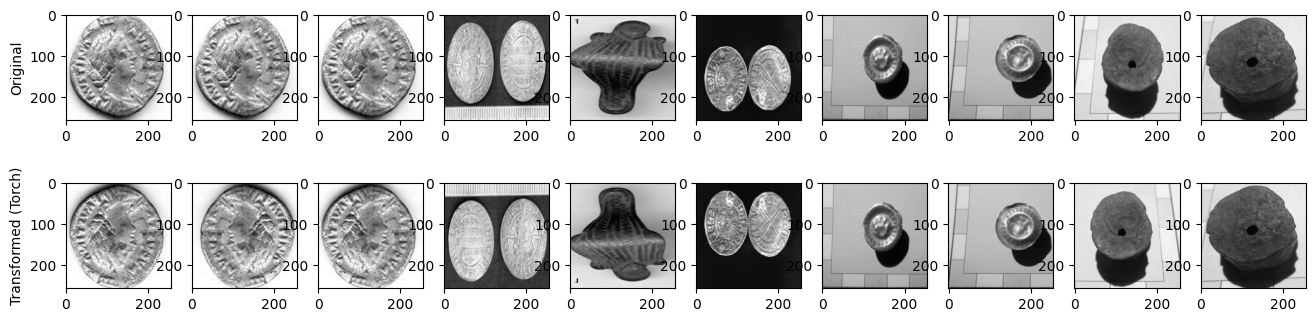

In [4]:
# Get a mini-batch from the train_loader and show differences before and after transformation
# Get the first 10 images from the train_loader
X, y = next(iter(coin_loader))

fig, axs = plt.subplots(2, 10, figsize=(16, 4))

# Loop over the first 10 images
for i in range(10):
    # Original images
    axs[0, i].imshow(coin_dataT[i, 0, :, :].detach().numpy(), cmap='gray')
    # Transformed images
    axs[1, i].imshow(X[i, 0, :, :].detach().numpy(), cmap='gray')

# Set labels
axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Transformed (Torch)')

plt.show()

In [77]:
# https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
# Paper: https://arxiv.org/abs/1706.03762 
# Tutorial: https://www.akshaymakes.com/blogs/vision-transformer
# https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853
# MUST READ: https://github.com/labmlai/annotated_deep_learning_paper_implementations


# Using the convolution kernel for ease of implementation and patch embeddings - First step
class PatchEmbeddings(nn.Module):
    def __init__(
        self,
        d_model: int, 
        patch_size: int, 
        in_channels: int 
    ):
        super().__init__()

        # Sliding window approach - Size(Kernel)=Size(Stride)
        self.conv = nn.Conv2d(
            in_channels = in_channels, 
            out_channels = d_model, 
            kernel_size = patch_size, 
            stride = patch_size
        )

    def forward(self, x: torch.Tensor):
        print(f'x shape before patch embedding: {x.shape}')
        x = self.conv(x)
        d, h, w = x.shape # bs = batch size, c = channels, h = height, w = width. Removed: bs, 
        print(f'Length of x (#batches): {len(x)}')
        print(f'x[0] d_model d: {d}')
        # print(f'x[1] Batch Size bs: {bs}')
        print(f'x[2] Height h of the image patch: {h}')
        print(f'x[3] Width w of the image patch: {w}')
        x = x.permute(1,2,0) # permute to tesnor(height, width, batch_size, channels). Removed: x = x.permute(2,3,0,1)
        print(f'Permuted x.shape {x.shape}')
        x = x.view(h * w, d) # Reshape into: tensor(h * w, bs, c)
        print(f'After patch embedding x.shape: {x.shape}')
        return x
        

# Relative positional Encoding - Second step
class PositionalEmbedding(nn.Module): 
    def __init__(
        self, 
        d_model: int, 
        max_len: int = 256 # Number of maximum patches - 256 = 16x16 patches
    ):
        super().__init__()

        self.positional_encodings = nn.Parameter(torch.zeros(max_len, 1, d_model), requires_grad=True)

    def forward(self, x: torch.Tensor):
        pe = self.positional_encodings[:x.shape[0]]
        return x + pe

# The classification step (last step)
class ClassificationHead(nn.Module):
    def __init__(
        self, 
        d_model: int, 
        n_hidden: int, 
        n_classes: int
    ):
        super().__init__()

        self.linear1 = nn.Linear(d_model, n_hidden) # Full FFN with n hidden layers
        self.act = nn.ReLU() 
        self.linear2 = nn.Linear(n_hidden, n_classes) # Last - Predicts

    def forward(self, x: torch.Tensor):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        return x

# Our transformer model i.e. contains the encoder - middle step
class VisionTransformer(nn.Module):
    def __init__(
        self, 
        n_layers: int, # Number of transformer layers
        patch_emb: PatchEmbeddings, # patch embedding layers
        pos_emb: PositionalEmbedding,  # PE 
        classification: ClassificationHead # Classification head
    ):
        super().__init__()

        self.patch_emb = patch_emb # x is passed
        self.pos_emb = pos_emb # x is passed 
        self.classification = classification # x is passed 
        self.cls_token = nn.Parameter(torch.rand(1, 1, d_model), requires_grad=True)  # Learnable class token
        self.transformer_encoder_layer = nn.TransformerEncoderLayer( # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html
            d_model = d_model,
            nhead = n_heads,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            activation = activation,
            batch_first = batch_first,
            norm_first = norm_first,
            bias = bias
        )
        self.transformer_encoder = nn.TransformerEncoder( # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
            encoder_layer = self.transformer_encoder_layer,
            num_layers = n_layers, # n times encoder layers
            norm = layer_norm
        )
        self.class_tokens = nn.Parameter(torch.rand(n_classes, 1, d_model), requires_grad=True)

    def forward(self, x: torch.Tensor):
        x = self.patch_emb(x)
        # Print tensor sizes for debugging
        print(f"Size of x: {x.size(0)}")
        # Adding the class token 
        cls_tokens = self.class_tokens.expand(x.size(1), -1, -1) 
        x = torch.cat([self.cls_token.expand(x.size(1), -1, -1), cls_tokens, x], dim=1) # Expand the learnable class token and concat to input sequence on d_model dimension
        x = self.pos_emb(x)
        x = self.transformer_encoder(x)
        x = self.classification(x)

        return x

# Hyperparameters 
d_model = 768 # 16x16 number of patches times the number of channels
n_heads = 8
dim_feedforward = 4096 # default
activation='gelu'
batch_first = False
norm_first = True
bias = True
dropout = 0.1
layer_norm = nn.LayerNorm(d_model)
n_classes = 2
n_layers = 8
n_image_channels = 3 
max_n_patches = 256
patch_size = 16 # 16x16
n_hidden = 2 # FFN hidden layers
class_tokens = ['coin', 'other']

# Model
vit_model = VisionTransformer(
    n_layers = n_layers, 
    patch_emb = PatchEmbeddings( # Patch emb
        d_model= d_model, 
        patch_size = patch_size, 
        in_channels = n_image_channels
    ), 
    pos_emb = PositionalEmbedding( # Positional encoding
        d_model = d_model,
        max_len = max_n_patches
    ), 
    classification = ClassificationHead( # Classification head 
        d_model = d_model, 
        n_hidden = n_hidden, 
        n_classes = n_classes
    )
)

# Loss function
loss_func = nn.BCEWithLogitsLoss() # BCE=−1/n​∑i=1​(y_i​log(yHat_​i​)+(1−y_i​)log(1−yHat_i​))

# Optimizer 
optimizer = Adam(model.parameters(), lr=.001)

# Summary of the model - https://pypi.org/project/torchinfo/
summary(
    model=vit_model,
    input_size=(3, 256, 256),  # bs, c, h, w
    verbose=1,  # 2 for full info
    col_names=["input_size", "num_params", "output_size", "mult_adds", "trainable"],
    mode = "train"
)

x shape before patch embedding: torch.Size([3, 256, 256])
Length of x (#batches): 768
x[0] d_model d: 768
x[2] Height h of the image patch: 16
x[3] Width w of the image patch: 16
Permuted x.shape torch.Size([16, 16, 768])
After patch embedding x.shape: torch.Size([256, 768])
Size of x: 256


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [PatchEmbeddings: 1, Conv2d: 2]

In [19]:
# Train the model on a minibatch for testing
from torch.optim import Adam

# Training loop
def train(model, loss_func, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        # Iterate over your dataset here
        for input_data, target in train_loader:
            optimizer.zero_grad()
            output = model(input_data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()


# Training
train(model, loss_func, optimizer, num_epochs=5)

NameError: name 'train_loader' is not defined